## Time Series Forecasting

A survey of statistical and deep learning models

## What's a time series

A set of observations at regular time steps

In [72]:
from IPython.display import IFrame

# Source: https://data.gov.sg/dataset/hdb-resale-price-index
print("HDB Resale Price Index (Univariate)")
IFrame('https://data.gov.sg/dataset/hdb-resale-price-index/resource/52e93430-01b7-4de0-80df-bc83d0afed40/view/14c47d07-1395-4661-8466-728abce27f5f', width=600, height=400)

HDB Resale Price Index (Univariate)


In [73]:
from IPython.display import IFrame

# Source: https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual
print("Annual Average Weekly Paid Hours Worked Per Employee, By Industry And Type Of Employment (Multi-variate)")
IFrame('https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual/resource/dd2147ce-20b7-401c-ac8f-8dbcc0d8e0d9/view/431f44b1-e58d-4131-998d-7e7aeee14479', width='600', height='400')

Annual Average Weekly Paid Hours Worked Per Employee, By Industry And Type Of Employment (Multi-variate)


## Time Series Decomposition

- For analysis
- Split into trend, cyclic, seasonal, noise
- Multiplicative or additive

## Walkthrough: Time Series Decomposition
1. Go to https://data.gov.sg/dataset/hdb-resale-price-index
2. Click on the `Download` button
3. Unzip and extract the `.csv` file. Note that path to that file for use later.

We will use the [StatsModels](https://www.statsmodels.org/stable/index.html) Python library to perform the decomposition. 

This library will also be used later to perform statistical analysis. [Pandas](https://pandas.pydata.org/pandas-docs/stable/timeseries.html) is also useful for manipulating time series data.

In [28]:
"""Walkthrough: Time Series Decomposition"""

#!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import pandas as pd

# ==================================================================
# Update this path to match your actual path
data_path = 'D:\\tmp\\hdb-resale-price-index\\housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv'

# load data
df = pd.read_csv(data_path)

# print first few rows
df.head(5)

,quarter,index
0,1990-Q1,24.3
1,1990-Q2,24.4
2,1990-Q3,25.0
3,1990-Q4,24.7
4,1991-Q1,24.9


### Setting the DateTimeIndex

From the table above, we can confirm it is indeed a quarterly distribution. 

`seasonal_decompose` ([docs](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)) expects a DateTimeIndex to indicate the frequency of the time series. 

To do this, we set the `DataFrame.index` property as a `pandas.DatetimeIndex` ([docs](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#generating-ranges-of-timestamps)) with a quarterly frequency.

In [58]:
num_data_entries = df.shape[0]

# generate a date range with a quarter end frequency
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases
start = pd.datetime(1990, 1, 1)
dr = pd.date_range(start, periods=num_data_entries, freq='Q')

# set the DataFrame.index
df.index = pd.DatetimeIndex(dr)

# print again to make sure the index and 'quarter' columns match
df.head(5)

,quarter,index
1990-03-31,1990-Q1,24.3
1990-06-30,1990-Q2,24.4
1990-09-30,1990-Q3,25.0
1990-12-31,1990-Q4,24.7
1991-03-31,1991-Q1,24.9


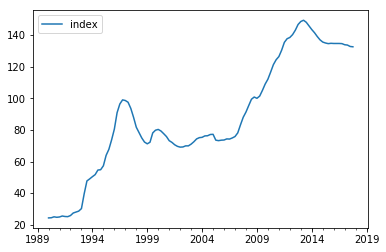

In [59]:
# plot the raw data, how that we have a DatetimeIndex
ax = df.plot()

## Seasonal Decompose

Now we are ready to decompose.  Let's try two models: `additive` and `multiplicative`.

You can find the definitions in the [StatsModels documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html), but in a nutshell, the `additive` model "adds up" the components, while the `multiplicative` model "multiplies" the components together.

Additive: $$y(t) = Trend + Seasonal + Residual$$

Mulplicative: $$y(t) = Trend * Seasonal * Residual$$

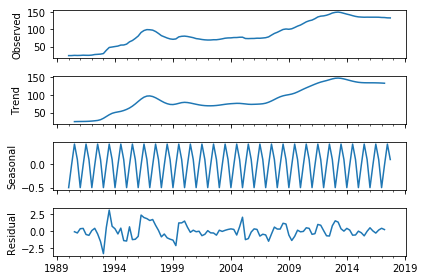

In [66]:
# it's a bit confusing, but `index` here refers to the HDB resale price index,
# not the DataFrame.index (for time series)
additive = seasonal_decompose(df.get('index'), model='additive')
additive.plot()
plt.show()

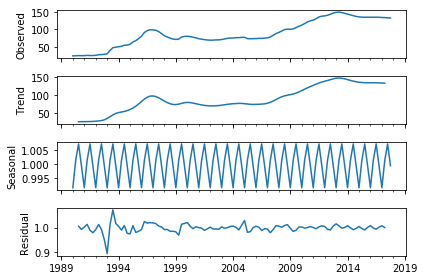

In [69]:
multiplicative = seasonal_decompose(df.get('index'), model='multiplicative')
multiplicative.plot()
plt.show()

## Observations

- There is a strong seasonal component. The component values are available as part of the object returned by `seasonal_decompose`
- The multiplicative model seems like a better fit, because the resulting residuals are smaller. In general, residuals (noise) are difficult to fit statistically.
- series_decompose is a naive method. For a more advanced decomposition library, see [STLDecompose]( https://github.com/jrmontag/STLDecompose/blob/master/STL%20usage%20example.ipynb)

In [71]:
# print out the first few elements of each seasonal component
print('Multiplicative model: Seasonal component')
print(multiplicative.seasonal[:10])

print('Additive model: Seasonal component')
print(additive.seasonal[:10])

Multiplicative model: Seasonal component
1990-03-31    0.991657
1990-06-30    1.001456
1990-09-30    1.007333
1990-12-31    0.999553
1991-03-31    0.991657
1991-06-30    1.001456
1991-09-30    1.007333
1991-12-31    0.999553
1992-03-31    0.991657
1992-06-30    1.001456
Freq: Q-DEC, Name: index, dtype: float64
Additive model: Seasonal component
1990-03-31   -0.500694
1990-06-30   -0.021528
1990-09-30    0.425231
1990-12-31    0.096991
1991-03-31   -0.500694
1991-06-30   -0.021528
1991-09-30    0.425231
1991-12-31    0.096991
1992-03-31   -0.500694
1992-06-30   -0.021528
Freq: Q-DEC, Name: index, dtype: float64


## Forecasting

- Statistical: Auto-regressive, Moving average models

- Deep Learning: LSTMs

## Auto-regressive models

$AR(p): X_t=c + \sum_{i=1}^p \varphi_iX_{t-i} + \varepsilon_t$

Output ($X_t$) depends on past values ($X_{t-i}$) + white noise ($\varepsilon_t$)

## Fitting auto-regressive models

1. Use Autocorrelation to pick parameter $p$, which indicates how far back in time $X_{t-i}$ should go
2. Train model to fit data, minimizing mean squared error

## Walkthrough: Auto-regression

In this walkthrough, we'll take the dataset we've been working with and see if we can train an auto-regressive model for it.

Credits: borrowed heavily from https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [ ]:
"""Walkthrough: Auto-regression"""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# ==================================================================
# Update this path to match your actual path
data_path = 'D:\\tmp\\hdb-resale-price-index\\housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv'

# load data
df = pd.read_csv(data_path)

## Lag plots

A quick first test is to check if the data is random. If random, the data will not exhibit a structure in the lag plot.

We will use `pandas.plotting.lag_plot`: https://pandas.pydata.org/pandas-docs/stable/visualization.html#lag-plot

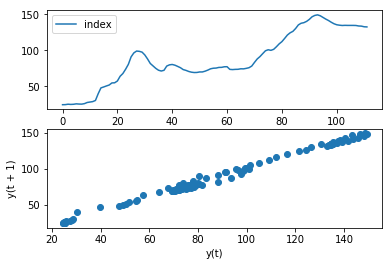

In [89]:
# try to see if there are correlations between X(t) and X(t-1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
df.plot(ax=ax1) # series plot
pd.plotting.lag_plot(df['index']) # lag plot

As a comparison, here's what the lag plot will look like for a random series:

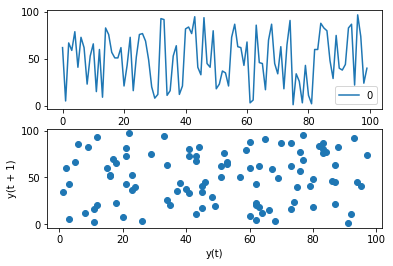

In [92]:
# generate a random series
random_df = pd.DataFrame(np.random.randint(0, 100, size=(100, 1)))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
random_df.plot(ax=ax1) # series plot
pd.plotting.lag_plot(random_df, ax=ax2) # lag plot (shows no correlation!)

So, it does look like there is correlation with the current and previous value of the HDB resale price index.

We are ready to move to the next step.

## Auto-correlation plots
The next test is use auto-correlation to pick a good value of `p` to use for the equation:

$AR(p): X_t=c + \sum_{i=1}^p \varphi_iX_{t-i} + \varepsilon_t$

We will use the `pandas.plotting.autocorrelation_plot`: https://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot

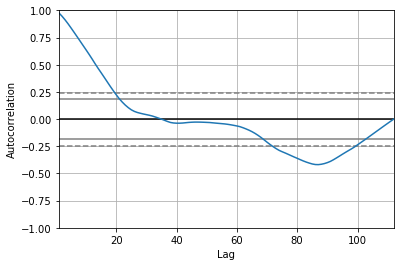

In [91]:
pd.plotting.autocorrelation_plot(df['index'])

Again, it is helpful to compare with a random series:

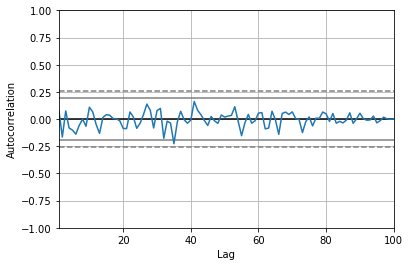

In [93]:
pd.plotting.autocorrelation_plot(random_df)

### Interpreting Auto-correlation plots

The [docs](https://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot) have a good explanation that we'll summarize here:

- Auto-correlation plots show the auto-correlation at different time lags (`p`)
- Random time series: the auto-correlations always hover around zero
- Non-random time series: find values of Lag where auto-correlations are outside of the 95% or 99% confidence band.
  - 95%: solid line
  - 99%: dashed line
- Both negative and positive auto-correlations are valid

### Auto-regression modeling: scenario

Since the dataset is about HDB quarterly resale prices, we can develop a model to predict the resale prices for the next year (4 quarters).

Let's create a baseline model based on the last observation. This will also help us setup the dataset for training.

#### Steps
1. The time series is a vector of X values. To model it, we will time-shift the dataset to produce two vectors (x, y).
    - input: $x = X_t$
    - output: $y = X_{t+1}$
2. We'll then split the (x, y) dataset into train and test
3. Run the baseline model to get predictions:
$$\hat{y} = BaselineModel(x)$$
4. Then compute the means square error:
$$score = MSE(y, \hat{y})$$

In [130]:
def create_lagged_dataset(data):
    """Creates the dataset used for time-series modeling
    Args:
        data: the time series data (X)
    Returns:
        the lagged dataset (X[t], X[t+1]) as a pandas.DataFrame
    """
    values = pd.DataFrame(data)
    df = pd.concat([values.shift(1), values], axis=1) # concat in the column axis
    df.columns = ['t-1', 't']
    return df
    
def train_test_split(data, split_percent=10):
    """Splits the dataset into train and test sets
    Note that for time series data, we should not use random split
    because sequence is important.
    We'll just split by taking the last split_percent values
    
    Args:
        data: the dataset (x, y)
    Returns:
        tuple: (train, test) as pandas.DataFrames
    """
    split_index = int(((1-split_percent)/100) * data.shape[0])
    
    x = data.values
    train, test = x[1:split_index], x[split_index:]
    
    train_df = pd.DataFrame.from_records(train, columns=['t-1', 't'])
    test_df = pd.DataFrame.from_records(test, columns=['t-1', 't'])

    return train_df, test_df

def baseline_persistence_model(x):
    """Returns the current observation
    Args:
        x: the current observation
    Returns:
        the current observation
    """
    return x

dataset = create_lagged_dataset(df['index'])
print(dataset.head(5))

train, test = train_test_split(dataset)
print("Some train data:", train.head(5))
print("Some test data:", test.head(5))

    t-1     t
0   NaN  24.3
1  24.3  24.4
2  24.4  25.0
3  25.0  24.7
4  24.7  24.9
Some train data:     t-1     t
0  24.3  24.4
1  24.4  25.0
2  25.0  24.7
3  24.7  24.9
4  24.9  25.5
Some test data:      t-1      t
0  135.0  134.6
1  134.6  134.8
2  134.8  134.7
3  134.7  134.7
4  134.7  134.7
